<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [1]:
import pandas as pd
import torch
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Data loader

In [2]:
class PlanesDataset(Dataset):
    
    def __init__(self, annotation_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_json(annotation_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,idx + '.jpg')
        image = io.imread(img_name)
        #landmarks = self.landmarks_frame.iloc[idx, 1:]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        #sample = {'image': image, 'landmarks': landmarks}
        return image

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
planes_dataset = PlanesDataset(annotation_file='/home/alex/Рабочий стол/python/yandex/planes/labels.json',
                                    root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/')


In [5]:
image = planes_dataset['16']

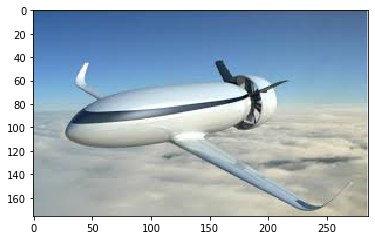

In [6]:
plt.imshow(image)
plt.show()